In [2]:
import requests
import os
import re
#import secretStash
import xarray as xr
import seawater as sw
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import warnings
from glob import glob
warnings.filterwarnings('ignore')
from datetime import timedelta,datetime
import matplotlib as mpl
%matplotlib inline

# Data Requests

Setup the data needed to make the request. This includes the specifics of the data and timeframe you would like and the necessary urls.

In [10]:
site = 'CP02PMUO' #'CP01CNPM','CP02PMCI','CP02PMCO','CP02PMUI','CP02PMUO','CP03ISPM','CP04OSPM'
node = 'WFP01'
instrument= '03-CTDPFK000'
method = 'telemetered'
stream = 'ctdpf_ckl_wfp_instrument'
api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv' #This is the base url for the API. This does not change.
time='?beginDT=2018-11-12T00:00:00.000Z&endDT=2018-12-06T00:00:00.000Z' # Date period of data to request. Must be in this datestring format to be appended to url.

# Create the request URL
data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))
data_request_url = data_request_url+time

### Make the Request
**Only run this once per request**. The data will be compiled and put together into your thredds server. This request requires an API username and password. These can be acquired by going to the [OOI Data Portal](https://ooinet.oceanobservatories.org/), log in with your personal/institutional account, and going to the *User Profile* page. This information can be directly input as strings in the `auth` argument below. The execution of this in this notebook is done using a separate file for privacy purposes labeled as `secretStash.py` which is imported along with the libraries and called below. The structure of the `secretStash.py` file which simply contains two lines:
`
ooiUser = 'YOUR API USERNAME'
ooiTkn = 'YOUR API PASSWORD'`


In [11]:
API_USERNAME = secretStash.ooiUser
API_TOKEN = secretStash.ooiTkn

r = requests.get(data_request_url, auth=(API_USERNAME, API_TOKEN))
data = r.json()
data

{'requestUUID': '8483476f-abd5-4bb1-ac8c-eb544918b8d2',
 'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/leviner@uw.edu/20200601T201120136Z-CP02PMUO-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/catalog.html',
 'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/leviner@uw.edu/20200601T201120136Z-CP02PMUO-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/catalog.html',
  'https://opendap.oceanobservatories.org/async_results/leviner@uw.edu/20200601T201120136Z-CP02PMUO-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument'],
 'sizeCalculation': 15901488,
 'timeCalculation': 60,
 'numberOfSubJobs': 2}

### Pull the data
Once the data is finished processing and you receive an email confirming your data is ready, you can pull the data. The cell below grabs the data from the thredds server and puts it into an xArray dataset indexed by time.

In [ ]:
url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets = [d.replace('\\', '/') for d in datasets]
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
ds = ds.chunk({'time': 100}) # Used for optimization
ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.

### Reformat and save the data
Once the data is local, we can convert it into a standard 2-dimensional time indexed table using pandas, then save the data to a .csv file for future use.

In [13]:
df = ds.to_array().to_pandas().T
df.to_csv('data/insts_Avery/'+site+'_ctd.csv')

# Data Analysis

These are the basic analyses and figures for use in the manuscript. Some of this will require equal-bin gridding, and some plot functions that take dataframe inputs are setup below.

In [19]:
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

def readDf(file): # Read the .csv files produced above in the data request section and return a pandas dataframe
    df = pd.read_csv(file)
    df.time = pd.to_datetime(df.time)
    df = df.set_index('time') #index by time
    dfCTD = df[['practical_salinity','ctdpf_ckl_seawater_conductivity','ctdpf_ckl_seawater_pressure','ctdpf_ckl_seawater_temperature']] # only keep wanted variables
    dfCTD['depth'] = sw.eos80.dpth(dfCTD.ctdpf_ckl_seawater_pressure, 39.9365) # convert pressure to depth in meters
    return dfCTD

def timeLinspace(df,start,end=False,day=0,hour=0,minute=0,sec=0): # create the 'x' variable of time for gridding done below
    x= []
    start = pd.to_datetime(start)
    if end:
        end = pd.to_datetime(end)
    else:
        end = df.index[-1]
    while start <= end:
        x.append(start)
        start = start+timedelta(days=day,hours=hour,minutes=minute,seconds=sec)
    return x

def profilerGird(df, yVar, zVars, yInt, start,end=False,day=0,hour=0,minute=0,sec=0,combine=False): # grid the data as a function of depth range and time.
    x = timeLinspace(df,start,end,hour=hour)
    y = np.arange(np.floor(yVar.min()),np.ceil(yVar.max())+1,yInt)
    zd={}
    ct = 0
    for zVar in zVars:
        zd["z{0}".format(ct)] = []
        for t in range(len(x)-1):
            zCur = np.zeros(len(y))
            for d in range(len(y)-1):
                zCur[d] = df[(df.index >=x[t]) & (df.index < x[t+1]) & (df.depth >=y[d]) & (df.depth < y[d+1])][zVar].mean()   
            zCur[zCur==0] = np.nan
            zd["z{0}".format(ct)].append(zCur)   
        if combine:
            zd["z{0}".format(ct)] = np.nanmean(zd["z{0}".format(ct)],axis=0)
        ct+=1
    return x,y,zd

def quickProfile(y,d): # For producing quick depth vs. variable profile figure
    for i in range(len(d)):
        ax1 = plt.subplot(1,len(d),i+1)
        ax1.plot(d[list(d0.keys())[i]],y)
        ax1.invert_yaxis()
        ax1.grid()
        if i == 0:
            ax1.set_ylabel('Depth (m)')
            
def quickProfileComp(d,title,leg=False): # For producing quick Y vs Y plots, such as TS diagrams. see calls below for implementation.
    for di in d:
        plt.axis([32.5,36,10,18])
        x = np.linspace(32.5, 36, 50)
        y = np.linspace(10, 18, 50)
        X, Y = np.meshgrid(x, y)
        contours = plt.contour(X, Y, sw.eos80.dens0(X, Y), colors='grey');
        plt.clabel(contours, inline=True, fontsize=14)
        plt.plot(di[list(di.keys())[0]],di[list(di.keys())[1]],linewidth=2)
        if leg:
            plt.legend(['Before','During','After'],loc='upper right')
        #plt.title(title)

One additional data ask that was done to shrink the files was to remove all of the internal log numbers and unnecessary time stamps in each of the csv files and rewrite them. This only needs to be done once, and it will speed up future operations on reading the dataframes:

In [45]:
for file in glob('../data/ProfilerCTD/*.csv'):
    dfCTD = readDf(file)
    dfCTD.to_csv(file)

Lets take a quick look to confirm that there is a profile near local noon and what that looks like.

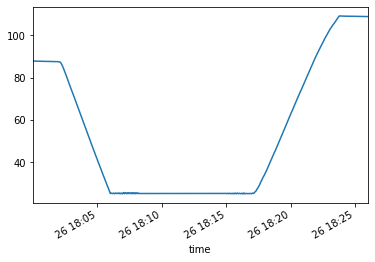

In [3]:
site = 'CP01CNPM'
dfCTD = readDf('../data/ProfilerCTD/'+site+'_ctd.csv')
dfCTD[(dfCTD.index >=  '2018-11-26 16:00:00') &( dfCTD.index <'2018-11-26 19:01:00')].depth.plot()

### WOA November Climatology

Read in a datasheet of the oxygen, salinity, and temperature from the PMCO site location in the World Ocean Atlas

In [13]:
dfWOA = pd.read_csv('../data/ProfilerCTD/woaDecadalAverage.csv')
dfWOA.temp.mean()

14.32653557227273

### Profile plots - Comparing Storms

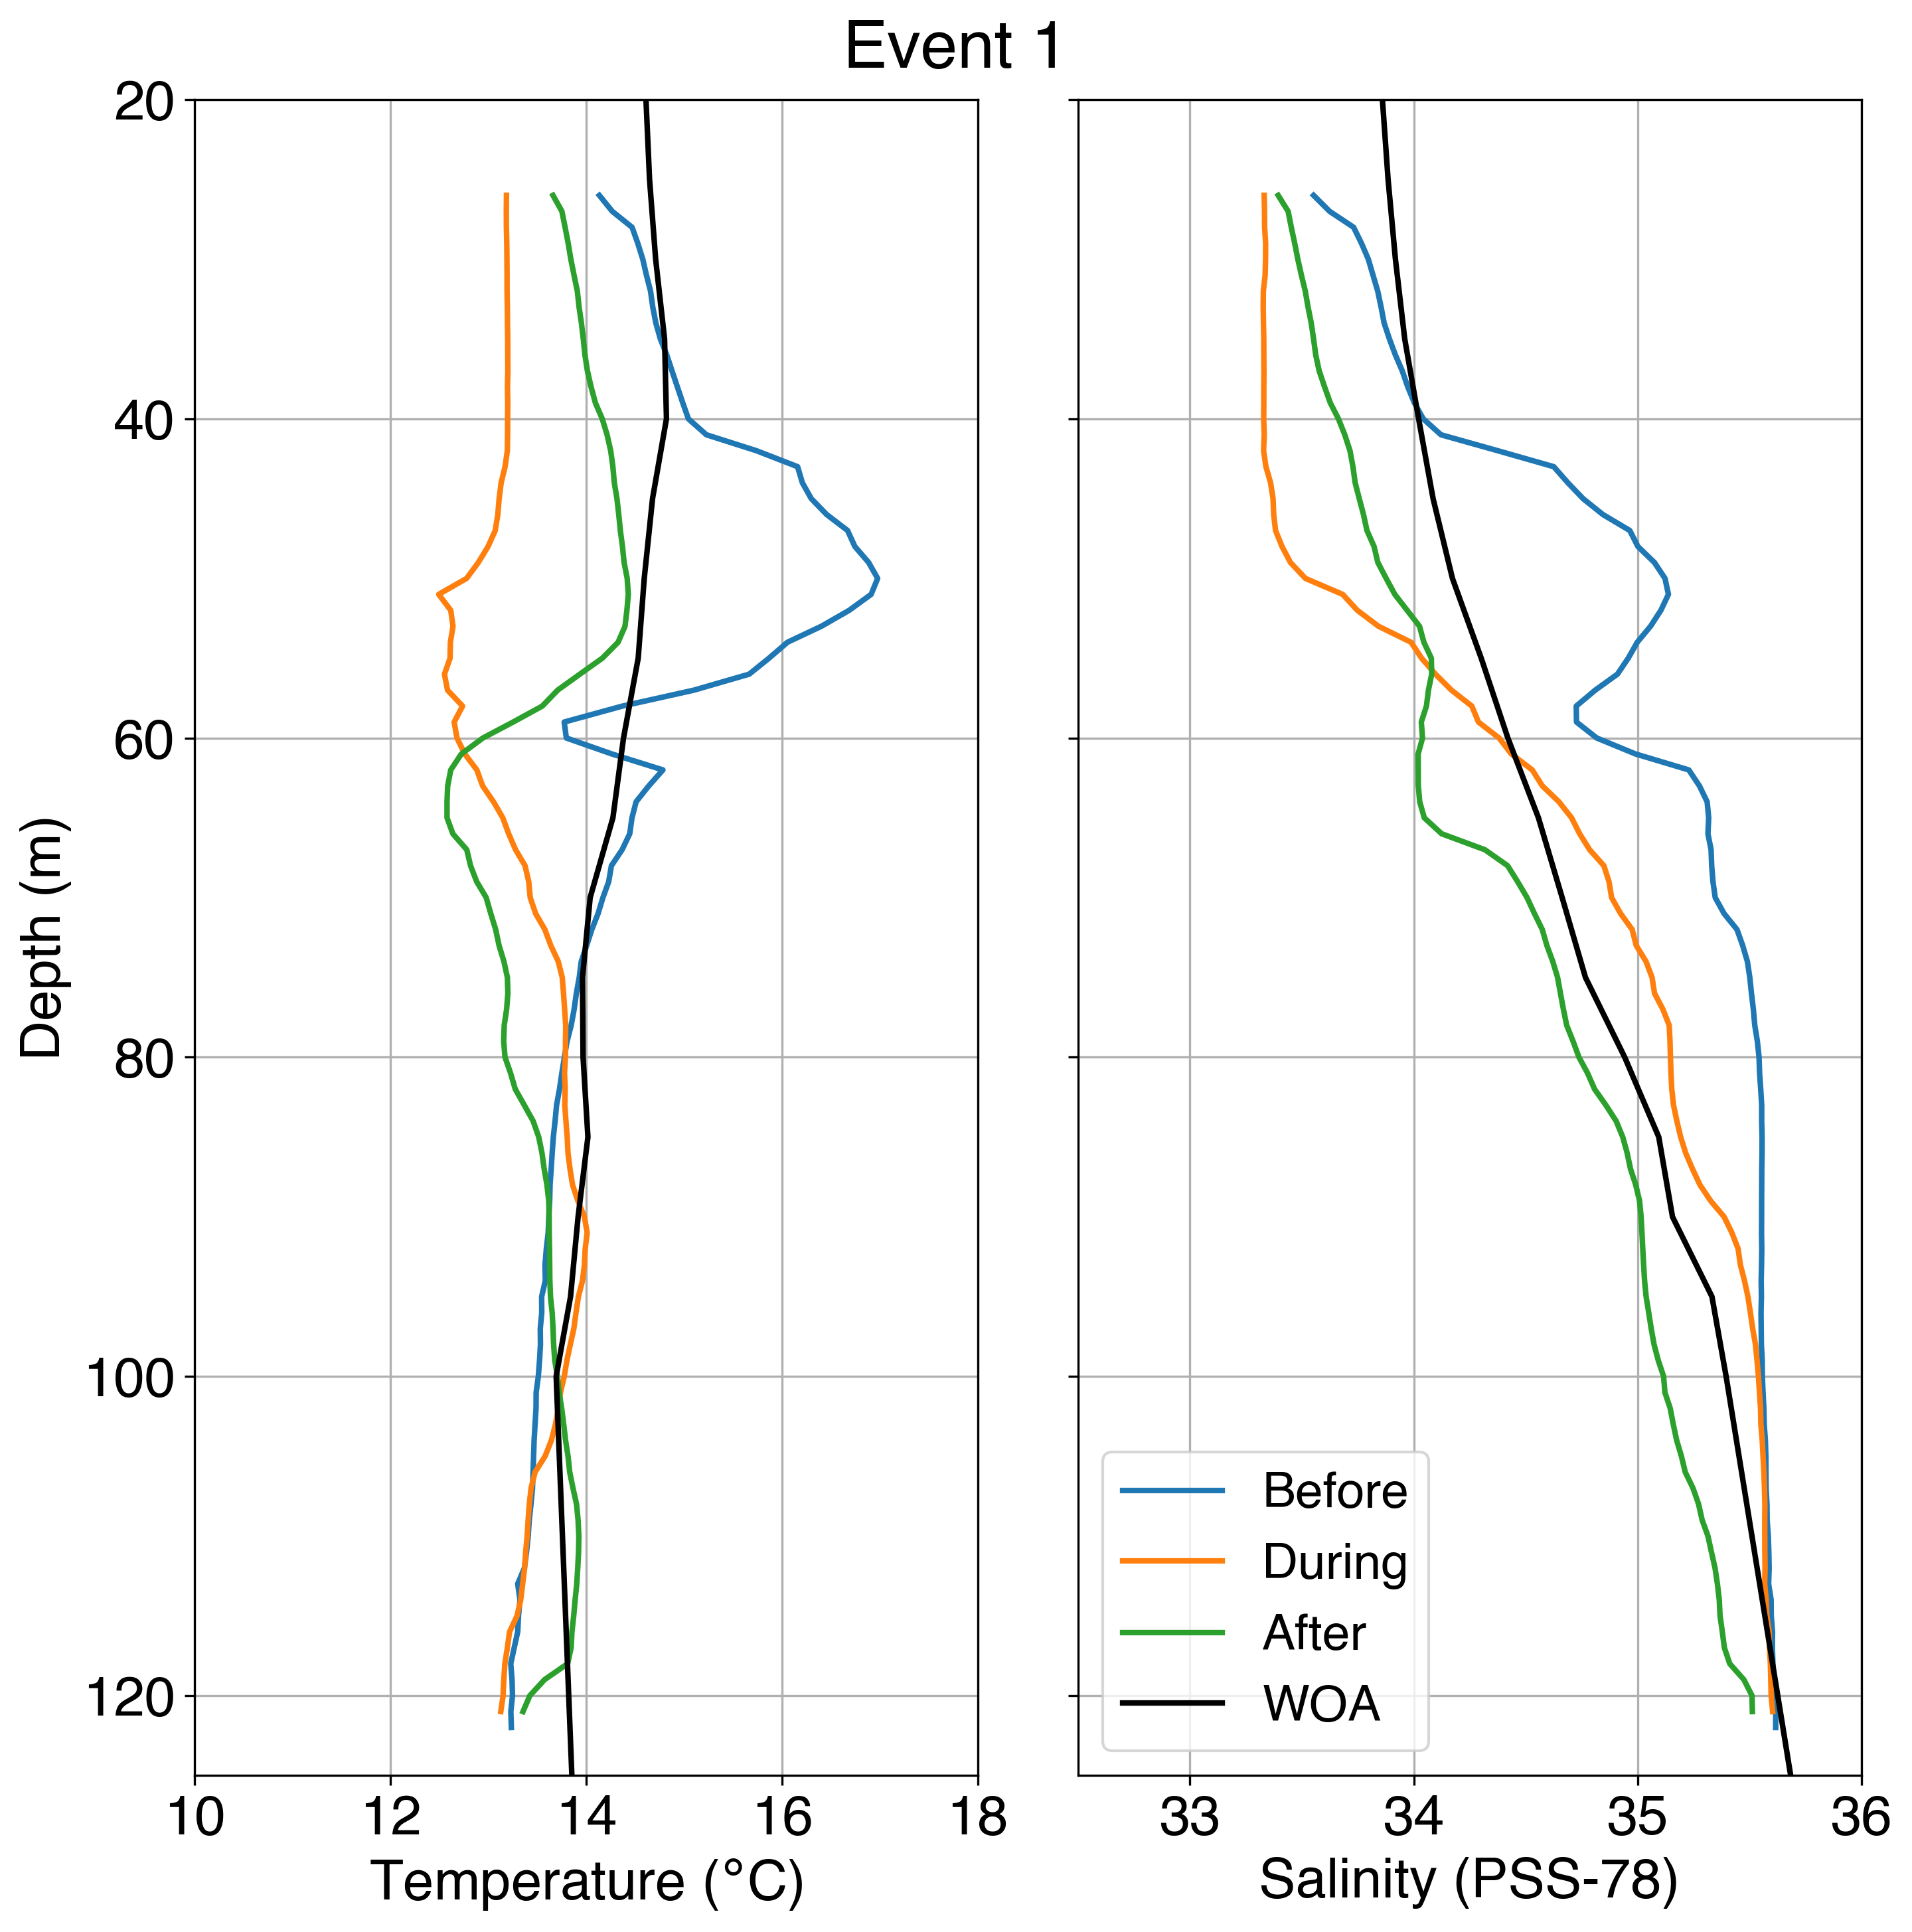

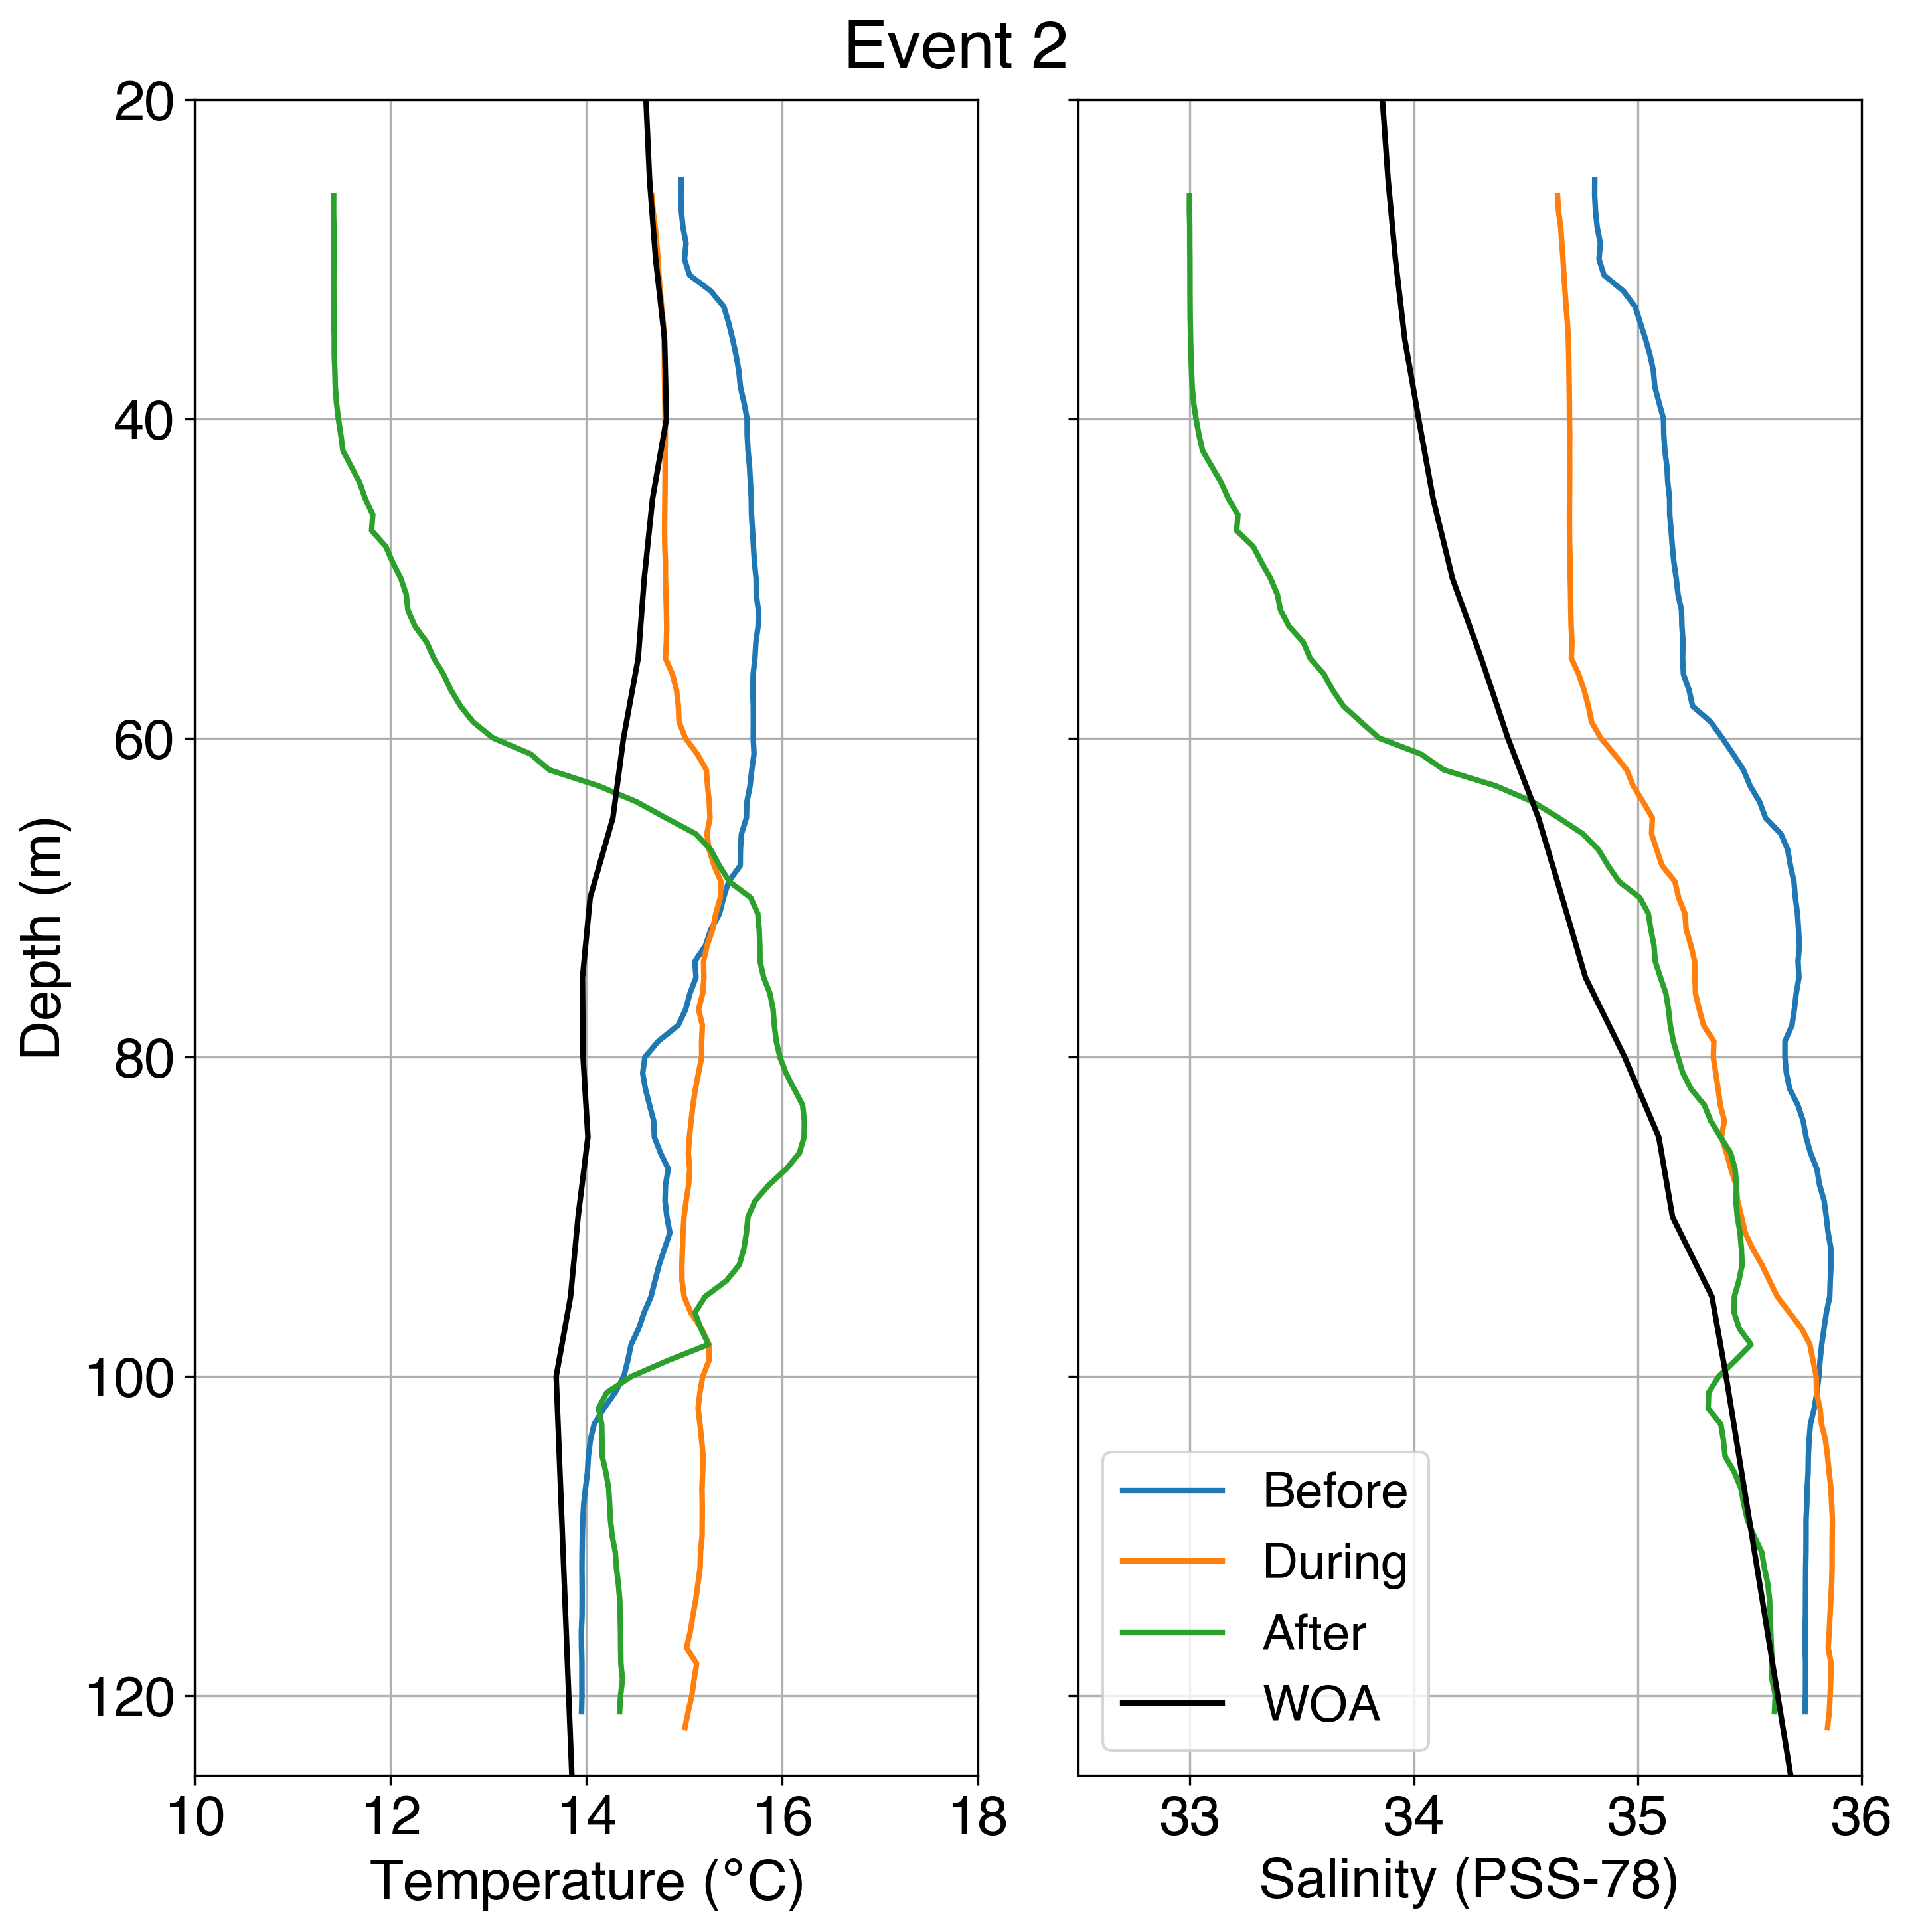

In [25]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

fig = plt.figure(figsize=(10,10),dpi=300)
dataDir = '../data/ProfilerCTD/'
site = 'CP02PMCO'
dfCTD = readDf(dataDir+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
ax1 = plt.subplot(121)
ax1.plot(d0['z1'],y)
ax1.plot(d1['z1'],y)
ax1.plot(d2['z1'],y)
ax1.plot(dfWOA.temp.values, dfWOA.depth.values,'k')
ax1.set_xlim([10,18])
ax1.set_ylim([20,125])
ax1.invert_yaxis()
ax1.grid()
ax1.set_xlabel('Temperature ($\degree$C)')
ax1.set_ylabel('Depth (m)')
ax2 = plt.subplot(122)
ax2.plot(d0['z0'],y)
ax2.plot(d1['z0'],y)
ax2.plot(d2['z0'],y)
ax2.plot(dfWOA.salinity.values, dfWOA.depth.values,'k')
ax2.set_xlim([32.5,36])
ax2.set_ylim([20,125])
ax2.invert_yaxis()
ax2.set_yticklabels([])
ax2.set_xlabel('Salinity (PSS-78)')
ax2.grid()
plt.legend(['Before','During','After','WOA'],fontsize=18,loc='lower left')
fig.tight_layout()
fig.suptitle('Event 1')
fig.subplots_adjust(top=0.94)

fig = plt.figure(figsize=(10,10),dpi=300)
site = 'CP02PMCO'
dfCTD = readDf(dataDir+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-26 16:00:00',end='2018-11-26 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-28 16:00:00',end='2018-11-28 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-30 16:00:00',end='2018-11-30 19:01:00',hour=1,combine=True)
ax1 = plt.subplot(121)
ax1.plot(d0['z1'],y)
ax1.plot(d1['z1'],y)
ax1.plot(d2['z1'],y)
ax1.plot(dfWOA.temp.values, dfWOA.depth.values,'k')
ax1.set_xlim([10,18])
ax1.set_ylim([20,125])
ax1.invert_yaxis()
ax1.grid()
ax1.set_xlabel('Temperature ($\degree$C)')
ax1.set_ylabel('Depth (m)')
ax2 = plt.subplot(122)
ax2.plot(d0['z0'],y)
ax2.plot(d1['z0'],y)
ax2.plot(d2['z0'],y)
ax2.plot(dfWOA.salinity.values, dfWOA.depth.values,'k')
ax2.set_xlim([32.5,36])
ax2.set_ylim([20,125])
ax2.invert_yaxis()
ax2.set_yticklabels([])
ax2.set_xlabel('Salinity (PSS-78)')
ax2.grid()
plt.legend(['Before','During','After','WOA'],fontsize=18,loc='lower left')
fig.tight_layout()
fig.suptitle('Event 2')
fig.subplots_adjust(top=0.94)

### Profile plots - Storm 1 across sites

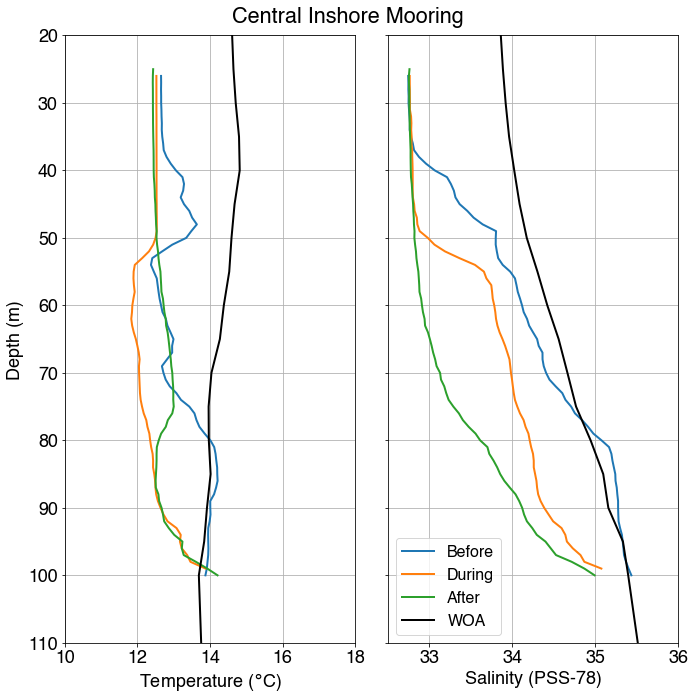

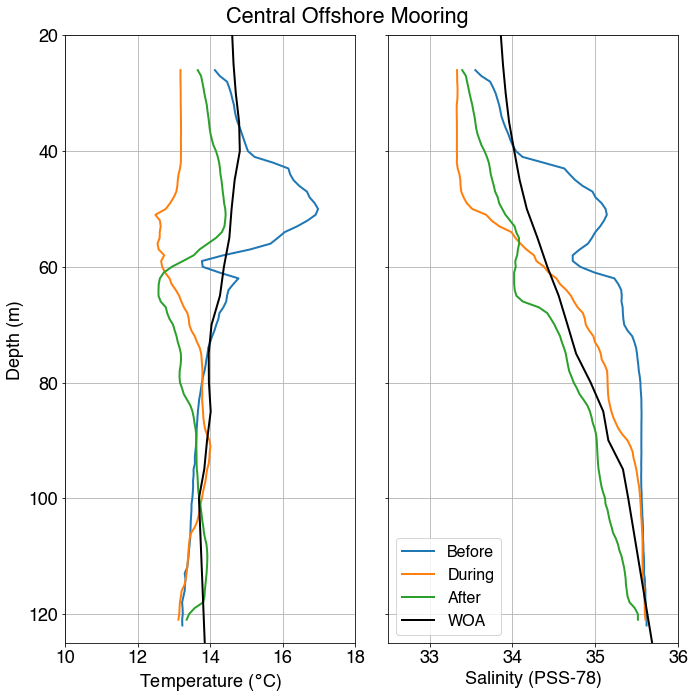

In [18]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 18
fig = plt.figure(figsize=(10,10))
dataDir = '../data/ProfilerCTD/'
site = 'CP02PMCI'
dfCTD = readDf(dataDir+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
ax1 = plt.subplot(121)
ax1.plot(d0['z1'],y)
ax1.plot(d1['z1'],y)
ax1.plot(d2['z1'],y)
ax1.plot(dfWOA.temp.values, dfWOA.depth.values,'k')
ax1.set_xlim([10,18])
ax1.set_ylim([20,110])
ax1.invert_yaxis()
ax1.grid()
ax1.set_xlabel('Temperature ($\degree$C)')
ax1.set_ylabel('Depth (m)')
ax2 = plt.subplot(122)
ax2.plot(d0['z0'],y)
ax2.plot(d1['z0'],y)
ax2.plot(d2['z0'],y)
ax2.plot(dfWOA.salinity.values, dfWOA.depth.values,'k')
ax2.set_xlim([32.5,36])
ax2.set_ylim([20,110])
ax2.invert_yaxis()
ax2.set_yticklabels([])
ax2.set_xlabel('Salinity (PSS-78)')
ax2.grid()
plt.legend(['Before','During','After','WOA'],fontsize=16,loc='lower left')
fig.tight_layout()
fig.suptitle('Central Inshore Mooring')
fig.subplots_adjust(top=0.94)

fig = plt.figure(figsize=(10,10))
site = 'CP02PMCO'
dfCTD = readDf(dataDir+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
ax1 = plt.subplot(121)
ax1.plot(d0['z1'],y)
ax1.plot(d1['z1'],y)
ax1.plot(d2['z1'],y)
ax1.plot(dfWOA.temp.values, dfWOA.depth.values,'k')
ax1.set_xlim([10,18])
ax1.set_ylim([20,125])
ax1.invert_yaxis()
ax1.grid()
ax1.set_xlabel('Temperature ($\degree$C)')
ax1.set_ylabel('Depth (m)')
ax2 = plt.subplot(122)
ax2.plot(d0['z0'],y)
ax2.plot(d1['z0'],y)
ax2.plot(d2['z0'],y)
ax2.plot(dfWOA.salinity.values, dfWOA.depth.values,'k')
ax2.set_xlim([32.5,36])
ax2.set_ylim([20,125])
ax2.invert_yaxis()
ax2.set_yticklabels([])
ax2.set_xlabel('Salinity (PSS-78)')
ax2.grid()
plt.legend(['Before','During','After','WOA'],fontsize=16,loc='lower left')
fig.tight_layout()
fig.suptitle('Central Offshore Mooring')
fig.subplots_adjust(top=0.94)

### Dataframe of profile statistics
Build a table of the before/during/after temperatures and salinity at all 7 of the profiler sites

In [38]:
dCTD = {}
dCTD['site'],dCTD['tMin'],dCTD['tMean'],dCTD['tMax'],dCTD['sMin'],dCTD['sMean'],dCTD['sMax'],dCTD['time'] = [[] for i in range(8)]
sites = ['CP01CNPM','CP02PMCI','CP02PMCO','CP02PMUI','CP02PMUO','CP03ISPM','CP04OSPM']
startTimes = ['2018-11-14 16:00:00','2018-11-16 16:00:00','2018-11-18 16:00:00']
endTimes = ['2018-11-14  19:01:00','2018-11-16  19:01:00','2018-11-18  19:01:00']
timeL = ['b','d','a']

for site in sites:
    for i in range(len(startTimes)):
        dfCTD = readDf('data/insts_Avery/'+site+'_ctd.csv')
        dCTD['site'].append(site)
        dCTD['time'].append(timeL[i])
        dCTD['tMin'].append(dfCTD[(dfCTD.index > startTimes[i]) & (dfCTD.index <endTimes[i])].ctdpf_ckl_seawater_temperature.min())
        dCTD['tMean'].append(dfCTD[(dfCTD.index > startTimes[i]) & (dfCTD.index <endTimes[i])].ctdpf_ckl_seawater_temperature.mean())
        dCTD['tMax'].append(dfCTD[(dfCTD.index > startTimes[i]) & (dfCTD.index <endTimes[i])].ctdpf_ckl_seawater_temperature.max())
        dCTD['sMin'].append(dfCTD[(dfCTD.index > startTimes[i]) & (dfCTD.index <endTimes[i])].practical_salinity.min())
        dCTD['sMean'].append(dfCTD[(dfCTD.index > startTimes[i]) & (dfCTD.index <endTimes[i])].practical_salinity.mean())
        dCTD['sMax'].append(dfCTD[(dfCTD.index > startTimes[i]) & (dfCTD.index <endTimes[i])].practical_salinity.max())
dfStats = pd.DataFrame(dCTD)
dfStats

,site,tMin,tMean,tMax,sMin,sMean,sMax,time
0,CP01CNPM,12.2083,13.347450,15.9230,32.828983,34.252125,35.468855,b
1,CP01CNPM,12.2574,13.229645,14.0893,33.084289,34.235859,35.542564,d
2,CP01CNPM,12.4739,13.473809,16.3330,33.010902,34.382051,35.462050,a
3,CP02PMCI,12.2793,13.243390,14.2230,32.741325,34.071419,35.437020,b
4,CP02PMCI,11.8076,12.584960,13.9502,32.760839,33.649435,35.095368,d
5,CP02PMCI,12.4160,12.988814,14.4479,32.743717,33.566890,35.071967,a
6,CP02PMCO,13.2256,14.090562,17.0333,33.417334,34.871226,35.619930,b
7,CP02PMCO,12.2455,13.294275,14.0374,33.321934,34.561459,35.606478,d
8,CP02PMCO,12.5628,13.652490,14.4520,33.248132,34.433827,35.527376,a
9,CP02PMUI,12.8653,13.444079,13.6176,32.605913,32.835074,33.584753,b


### T-S plots - spatial variability of 1st storm

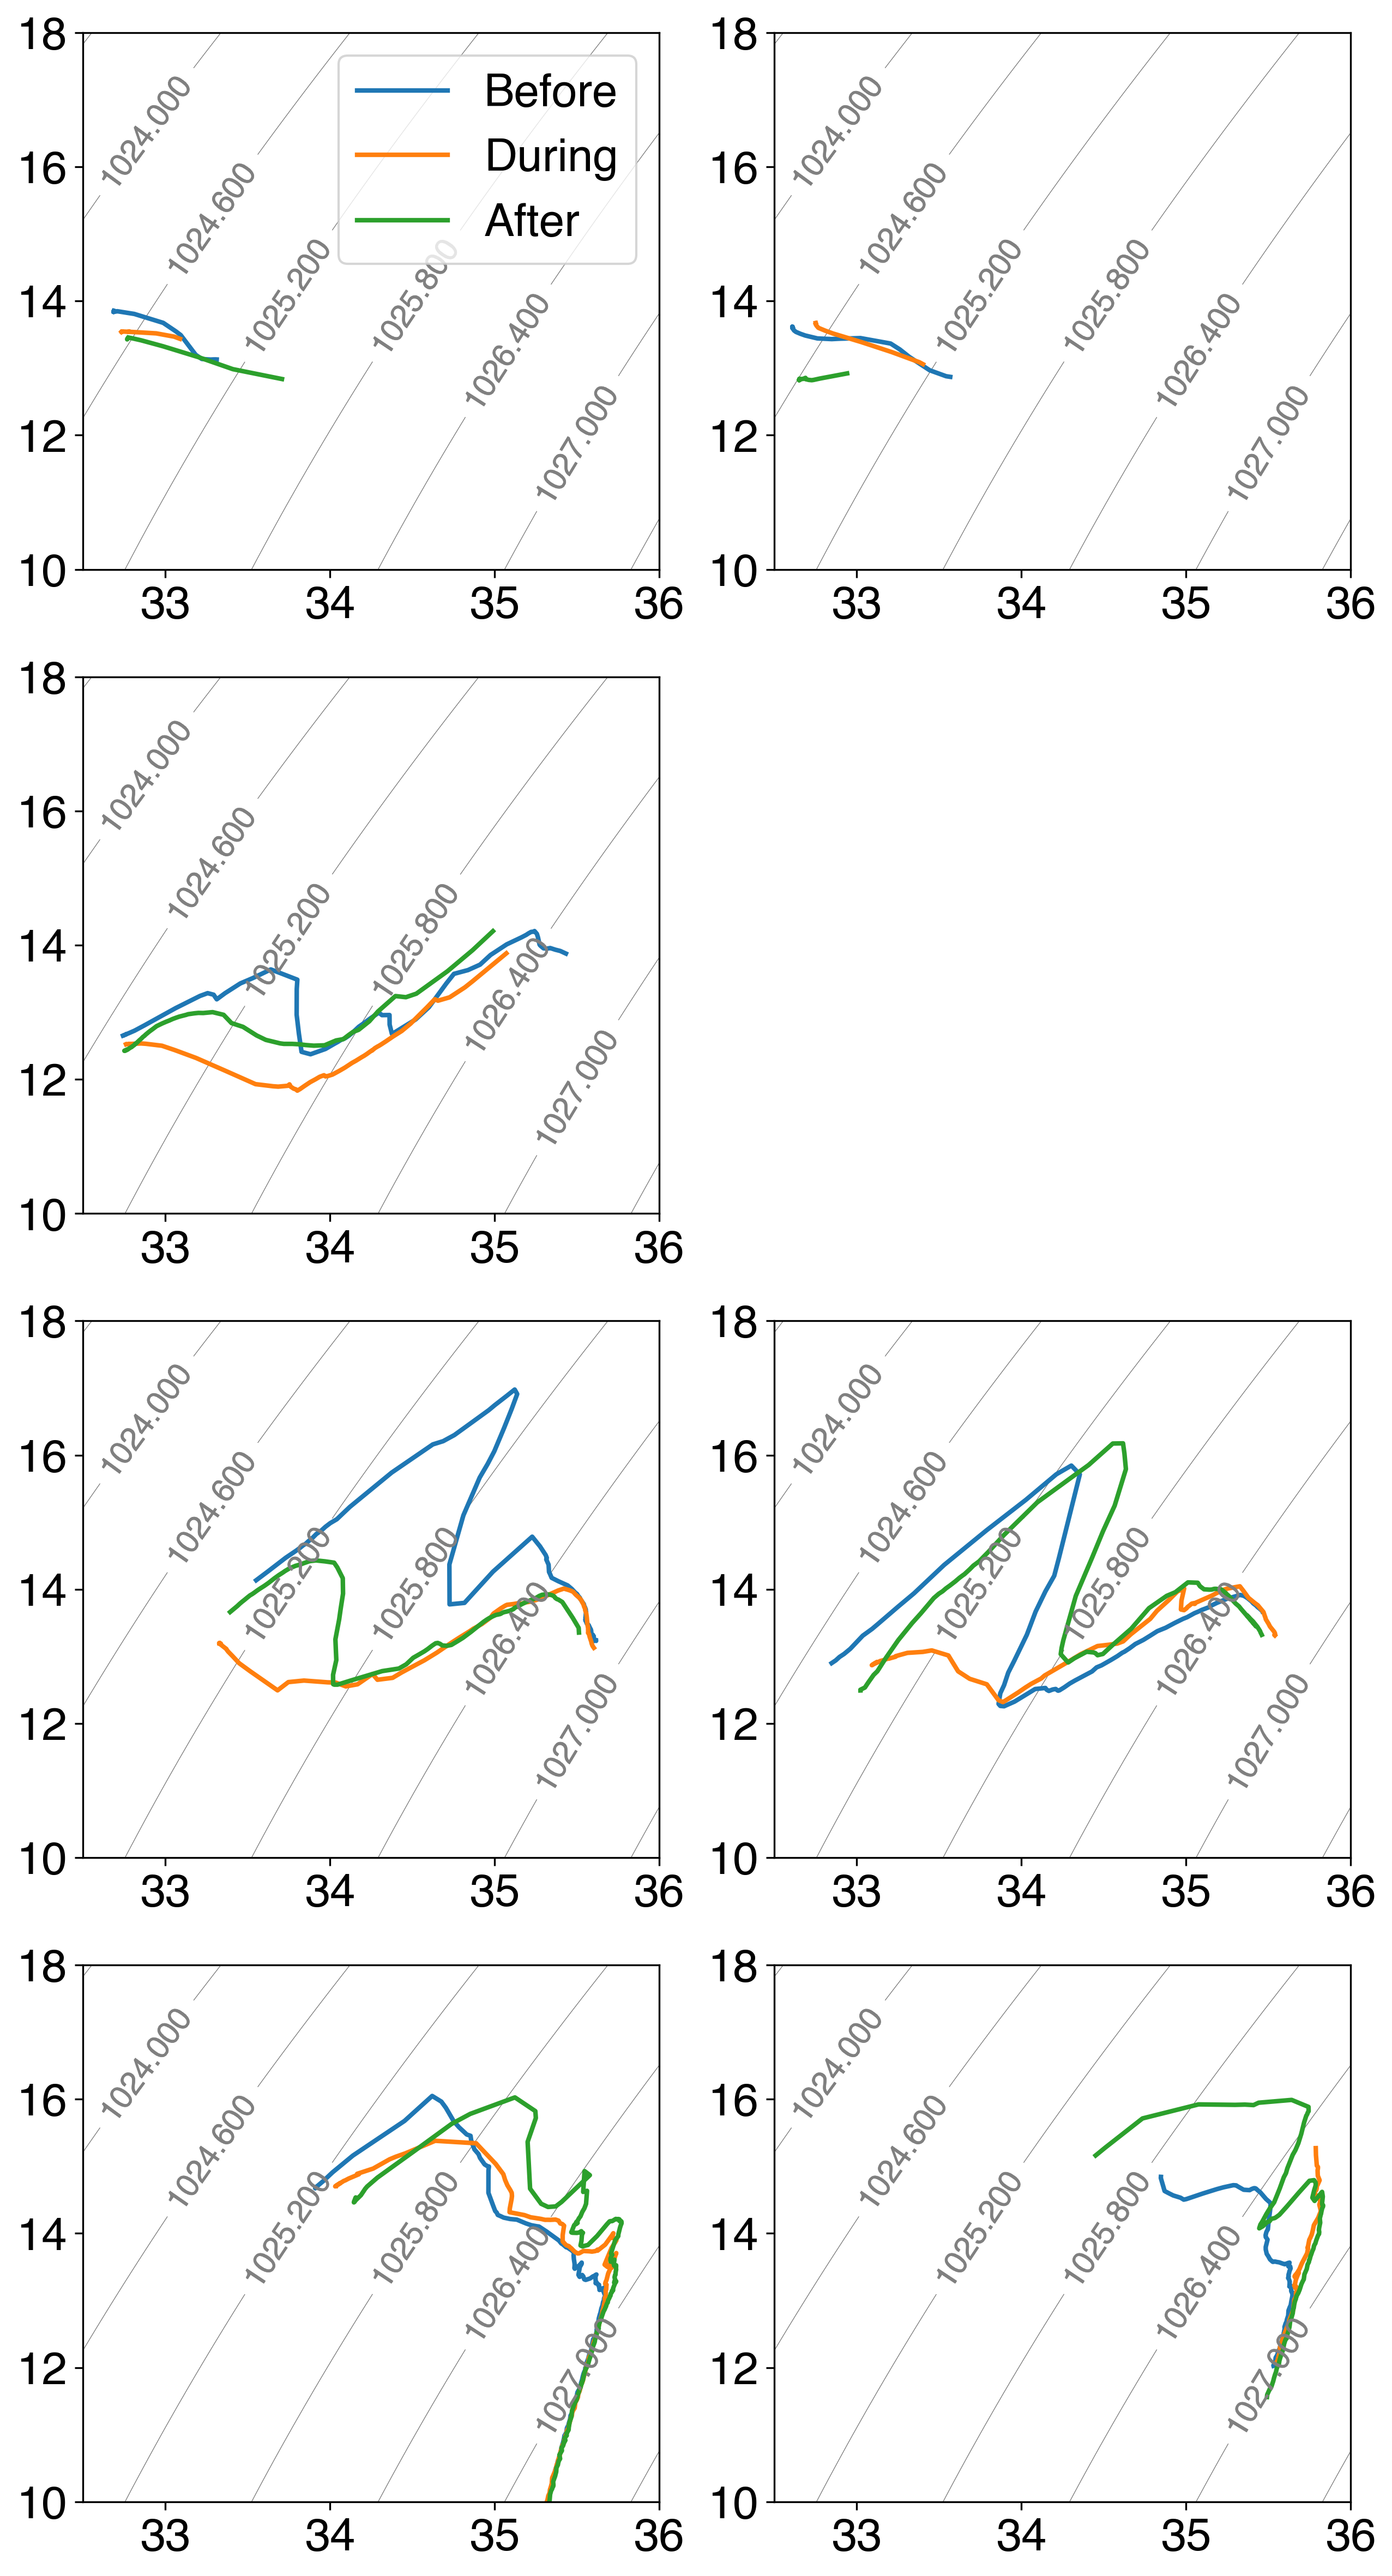

In [21]:
mpl.rcParams['lines.linewidth'] = .2
mpl.rcParams['font.size'] = 20
fig = plt.figure(figsize=(10,20),dpi = 300)
site = 'CP03ISPM'
dfCTD = readDf('../data/ProfilerCTD/'+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
plt.subplot(421)
quickProfileComp([d0,d1,d2],'Inshore',leg=True)

site = 'CP02PMUI'
dfCTD = readDf('../data/ProfilerCTD/'+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
plt.subplot(422)
quickProfileComp([d0,d1,d2],'Upstream Inshore')

site = 'CP02PMCI'
dfCTD = readDf('../data/ProfilerCTD/'+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
plt.subplot(423)
quickProfileComp([d0,d1,d2],'Central Inshore')

site = 'CP02PMCO'
dfCTD = readDf('../data/ProfilerCTD/'+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
plt.subplot(425)
quickProfileComp([d0,d1,d2],'Central Offshore')

site = 'CP01CNPM'
dfCTD = readDf('../data/ProfilerCTD/'+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
plt.subplot(426)
quickProfileComp([d0,d1,d2],'Central')

site = 'CP04OSPM'
dfCTD = readDf('../data/ProfilerCTD/'+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
plt.subplot(427)
quickProfileComp([d0,d1,d2],'Offshore')

site = 'CP02PMUO'
dfCTD = readDf('../data/ProfilerCTD/'+site+'_ctd.csv')
x,y,d0=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-14 16:00:00',end='2018-11-14 19:01:00',hour=1,combine=True)
x,y,d1=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-16 16:00:00',end='2018-11-16 19:01:00',hour=1,combine=True)
x,y,d2=profilerGird(dfCTD, dfCTD.depth, [dfCTD.columns[0],dfCTD.columns[3]],1, '2018-11-18 16:00:00',end='2018-11-18 19:01:00',hour=1,combine=True)
plt.subplot(428)
quickProfileComp([d0,d1,d2],'Upstream Offshore')
#plt.subplots_adjust(hspace=0.3)